In [96]:
import numpy as np
import os
import pandas as pd
import tools
from tqdm import tqdm
from matplotlib import pyplot as plt
import measures as ms
import seaborn as sns

import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from tempfile import TemporaryDirectory
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# install Rtrack
rtrack = importr('Rtrack')
rstatix = importr('rstatix')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params

In [33]:
path_exp = "/home/jovyan/data/PNN.A-CMWMRawData/"
path_probe_trials = "PNN.A-C.MWM.probe/"
fname_genotypes = "MWMGenotypes.xlsx"


## Load metadata

In [119]:
# metadata of each recording
df_info = tools.load_finfo_probe(path_exp+path_probe_trials, extract_platform_quadrants=True)

# genotype data for each individual
def handle_values(val):
    if isinstance(val, str) and '*' in val:
        return val.replace('*', '')  # Replace '*' with an empty string
    return val
df_genotypes = pd.read_excel(path_exp+fname_genotypes, converters={'Subj': handle_values}, usecols=[0, 1, 2])
df_genotypes.set_index('Subj', inplace=True)

# merge both
df_info = pd.merge(df_info, df_genotypes[['sex', 'Geno']], left_on='animal_id', right_index=True, how='left')

## Plot arena

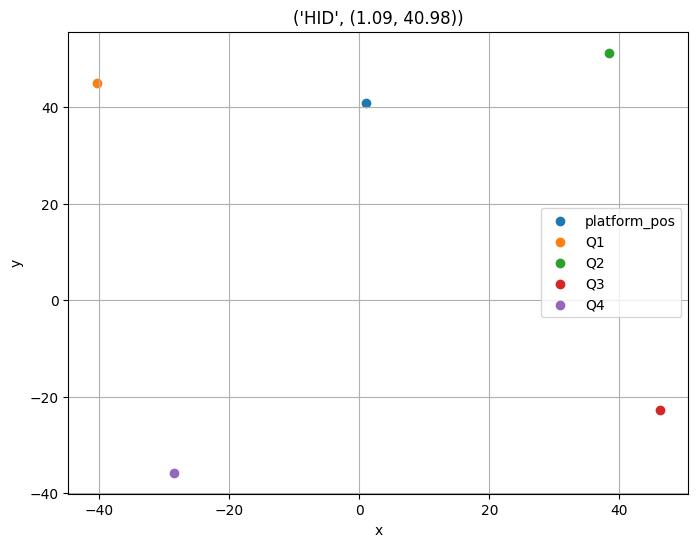

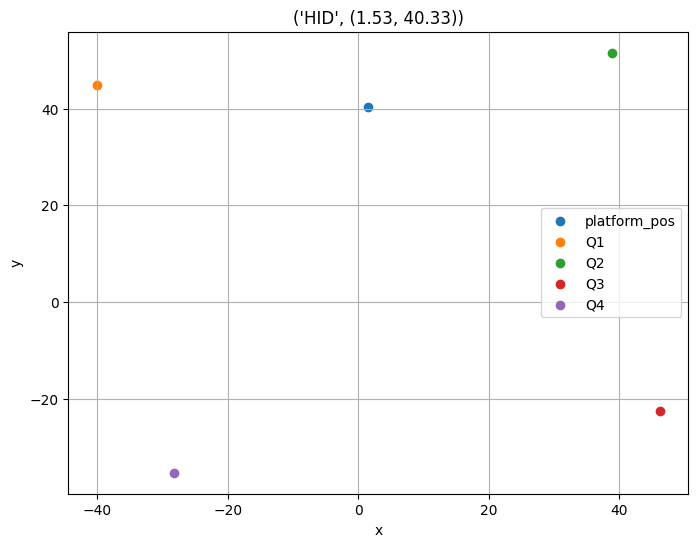

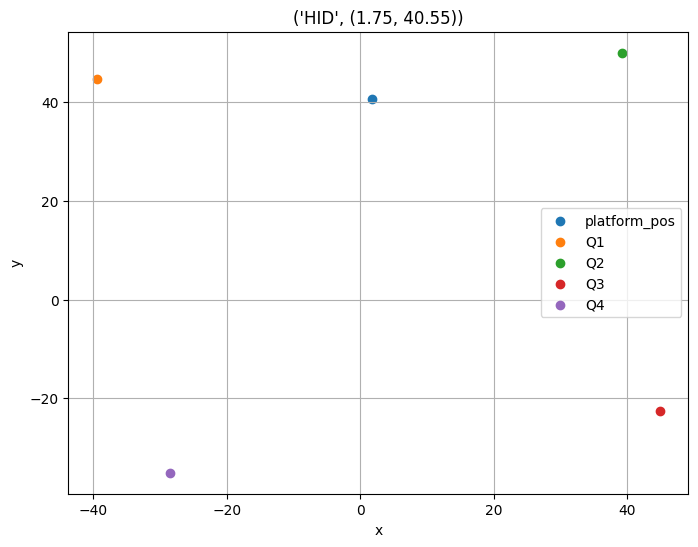

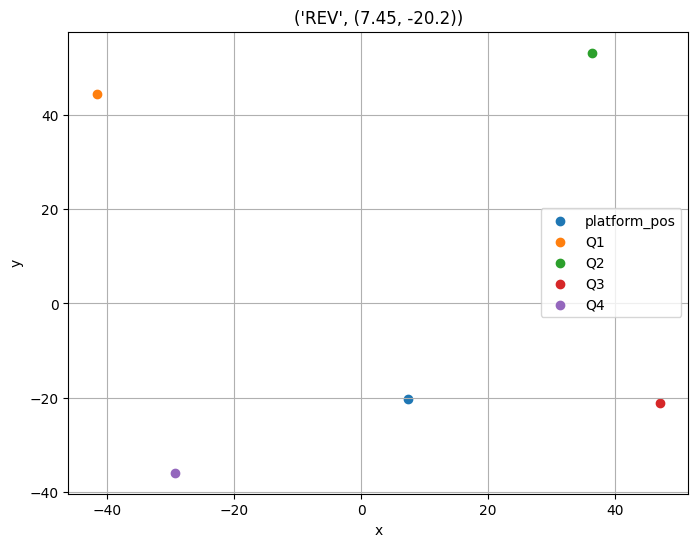

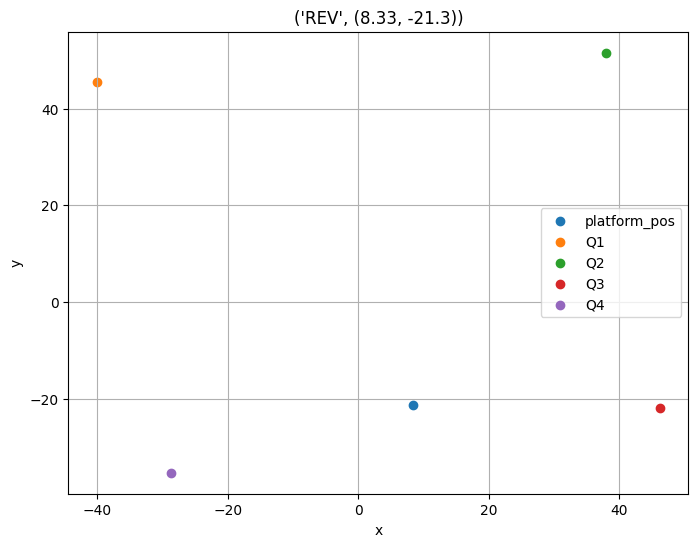

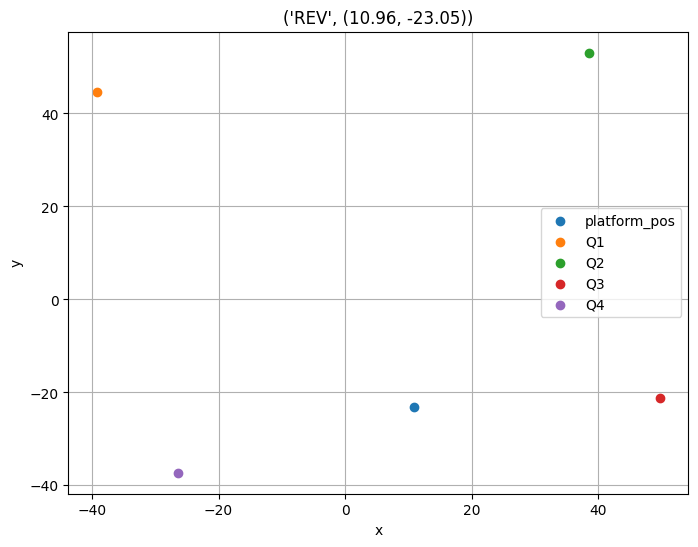

In [60]:
# points to plot
ls_pts_plot = ['platform_pos', 'Q1', 'Q2', 'Q3', 'Q4',]

gp_phase = df_info.groupby(['phase', 'platform_pos'])
for i, gp_i in gp_phase:
    row_i = gp_i.iloc[0]
    
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    
    for key in ls_pts_plot:
        plt.scatter(row_i[key][0], row_i[key][1], label=key)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(i)
    plt.legend()
    plt.grid(True)
    plt.show()

## Compute measures

In [115]:
ls_res = []

for i, row_i in tqdm(df_info.iterrows()):
    # load recording
    path_i = row_i['relative_path']
    rec = tools.load_recording(path_i)
    # extract positions
    xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
    # extract trial time
    t_trial = np.array(rec['Trial time']).flatten()
    # get recording time
    t_rec = np.array(rec['Recording time']).flatten()

    
    # compute measures
    # ----------------------
    res = {}
    
    # trial duration
    res['trial duration'] = np.max(t_trial)
    
    # path length
    res['path length'] = ms.path_length(xy)
    
    # mean distance to platform          
    res['mean distance to center of platform'
       ] = ms.mean_distance_to_point(xy, t_rec, row_i['platform_pos'])

    ls_res.append(res)
df_res = pd.DataFrame(ls_res)

df_info = df_info.join(df_res)

83it [00:28,  2.88it/s]


## Plot measures

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


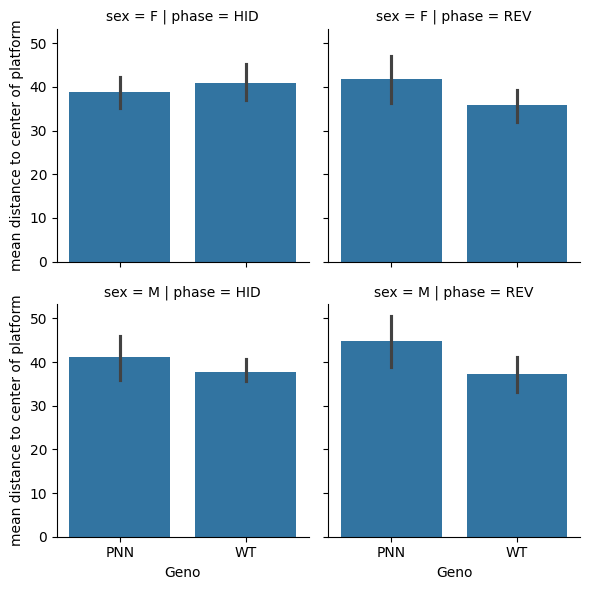

In [123]:
# Create a FacetGrid with 'phase' as the column variable and 'sex' as the row variable
g = sns.FacetGrid(data=df_info, col="phase", row="sex")

# Map a bar plot of trial duration to each grid item
g.map(sns.barplot, "Geno", "mean distance to center of platform")

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


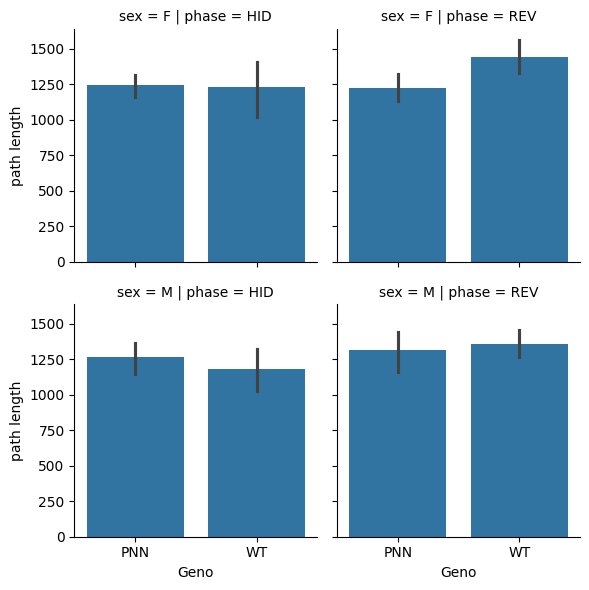

In [124]:
# Create a FacetGrid with 'phase' as the column variable and 'sex' as the row variable
g = sns.FacetGrid(data=df_info, col="phase", row="sex")

# Map a bar plot of trial duration to each grid item
g.map(sns.barplot, "Geno", "path length")

## Occupancy map

In [ ]:
ls_occ_map = []

for i, row_i in tqdm(df_info.iterrows()):
    path_i = row_i['relative_path']
    recording_i = tools.load_recording(path_i)
    xy = np.hstack([np.array(recording_i['X center']), np.array(recording_i['Y center'])])

## Strategy